# LangGraph

`LangGraph` es un marco de orquestación de bajo nivel para construir agentes controlables

Mientras que `LangChain` proporciona integraciones y componentes para agilizar el desarrollo de aplicaciones LLM, la biblioteca `LangGraph` permite la orquestación de agentes, ofreciendo arquitecturas personalizables, memoria a largo plazo y `human in the loop` para manejar de manera confiable tareas complejas.

## ¿Cómo funciona `LangGraph`?

`LangGraph` se basa en tres componentes:

 * **Nodos**: Representan las unidades de procesamiento de la aplicación, como llamar a un LLM, o a una herramienta. Son funciones de Python que se ejecutan cuando se llama al nodo.
   * Toman el estado como entrada
   * Realizan alguna operación
   * Devuelven el estado actualizado
 * **Edges**: Representan las transiciones entre los nodos. Definen la lógica de cómo se va a ejecutar el grafo, es decir, qué nodo se va a ejecutar después de otro. Pueden ser:
   * Directos: Van de un nodo a otro
   * Condicionales: Dependen de una condición
 * **State**: Representa el estado de la aplicación, es decir, que contiene toda la información necesaria para la aplicación. Se mantiene durante la ejecución de la aplicación. Es definido por el usuario, así que hay que pensar muy bien qué se va a guardar en él.

![LangGraph concept](https://pub-fb664c455eca46a2ba762a065ac900f7.r2.dev/LangGraph_concept.webp)

Todos los grafos de `LangGraph` comienzan desde un nodo `START` y terminan en un nodo `END`.

## Instalación de LangGraph

Para instalar `LangGraph` se puede usar pip:

```bash
pip install -U langgraph
```

o instalar desde conda:

```bash
conda install langgraph
```

## Instalación de módulo de Hugging Face y Anthropic

Vamos a usar un modelo de lenguaje de `Hugging Face`, por lo que necesitamos instalar su paquete de langgraph.

```bash
pip install langchain-huggingface
```

Para una parte vamos a usar `Sonnet 3.7`, luego explicaremos por qué. Así que tambien instalamos el paquere de `Anthropic`.

```bash
pip install langchain_anthropic
```

## API KEY de Hugging Face

Vamos a usar `Qwen/Qwen2.5-72B-Instruct` a través de `Hugging Face Inference Endpoints`, por lo que necesitamos una API KEY.

Para poder usar el `Inference Endpoints` de HuggingFace, lo primero que necesitas es tener una cuenta en HuggingFace. Una vez la tengas, hay que ir a [Access tokens](https://huggingface.co/settings/keys) en la configuración de tu perfil y generar un nuevo token.

Hay que ponerle un nombre. En mi caso, le voy a poner `langgraph` y habilitar el permiso `Make calls to inference providers`. Nos creará un token que tendremos que copiar

Para gestionar el token, vamos a crear un archivo en la misma ruta en la que estemos trabajando llamado`.env` y vamos a poner el token que hemos copiado en el archivo de la siguiente manera:

``` bash
HUGGINGFACE_LANGGRAPH="hf_...."
```

Ahora, para poder obtener el token, necesitamos tener instalado `dotenv`, que lo instalamos mediante

```bash
pip install python-dotenv
```

Y ejecutamos lo siguiente

In [1]:
import os
import dotenv

dotenv.load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

Ahora que tenemos un token, creamos un cliente. Para ello, necesitamos tener instalada la librería `huggingface_hub`. La instalamos mediante conda o pip.

``` bash
pip install --upgrade huggingface_hub
```

o

``` bash
conda install -c conda-forge huggingface_hub
```

Ahora tenemos que elegir qué modelo vamos a usar. Puedes ver los modelos disponibles en la página de [Supported models](https://huggingface.co/docs/api-inference/supported-models) de la documentación de `Inference Endpoints` de Hugging Face.

Vamos a usar `Qwen2.5-72B-Instruct` que es un modelo muy bueno.

In [2]:
MODEL = "Qwen/Qwen2.5-72B-Instruct"

Ahora podemos crear el cliente

In [3]:
from huggingface_hub import InferenceClient

client = InferenceClient(api_key=HUGGINGFACE_TOKEN, model=MODEL)
client

<InferenceClient(model='Qwen/Qwen2.5-72B-Instruct', timeout=None)>

Hacemos una prueba a ver si funciona

In [4]:
message = [
	{ "role": "user", "content": "Hola, qué tal?" }
]

stream = client.chat.completions.create(
	messages=message, 
	temperature=0.5,
	max_tokens=1024,
	top_p=0.7,
	stream=False
)

response = stream.choices[0].message.content
print(response)

¡Hola! Estoy bien, gracias por preguntar. ¿Cómo estás tú? ¿En qué puedo ayudarte hoy?


## API KEY de Anthropic

## Crear un chatbot básico

Vamos a crear un chatbot simple usando `LangGraph`. Este chatbot responderá directamente a los mensajes del usuario. Aunque es simple, nos servirá para ver los conceptos básicos de la construcción de grafos con `LangGraph`.

Como su nomre indica, `LangGraph` es una biblioteca para manejar grafos. así que comenzamos creando un grafo [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph).

Un `StateGraph` define la estructura de nuestro chatbot como una `máquina de estados`. Agregaremos `nodos` para representar el `llm` y `funciones` a nuestro chatbot que podrá llamar y `edges` para especificar cómo el bot debe hacer la transición entre estas funciones o `nodos`.

Así que comenzamos creando un `StateGraph` que necesita una clase `State` para manejar el estado del grafo. Como ahora vamos a crear una chatbot sencillo, solo necesitamos manejar una lista de mensajes en el estado.

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

La función [add_messages](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages) une dos listas de mensajes.

Llegarán nuevas listas de mensajes, por lo que se unirán a la lista de mensajes ya existente. Cada lista de mensajes contiene un `ID`, por lo que se agregan con este `ID`. Esto asegura que los mensajes solo se añaden, no se reemplazan, a no ser que un nuevo mensaje tenga el mismo `ID` que uno ya existente.

`add_messages` es una [reducer function](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers), es una función que se encarga de actualizar el estado.

El grafo `graph_builder` que hemos creado, recibe un estado `State` y devuelve un nuevo estado `State`. Además, actualiza la lista de mensajes.

 > **Concepto**
 >
 > Al definir un grafo, el primer paso es definir su `State`. El `State` incluye el esquema del grafo y las `reducer functions` que manejan actualizaciones del estado. 
 > 
 > En nuestro ejemplo, `State` es de tipo `TypedDict` (diccionario tipado) con una llave: `messages`.
 > 
 > `add_messages` es una `reducer function` que se utiliza para agregar nuevos mensajes a la lista en lugar de sobrescribirlos en la lista. Si una llave de un estado no tiene una `reducer function`, cada valor que llegue de esa clave sobrescribirán los valores anteriores.

Ahora vamos a agregar al grafo el nodo `chatbot`. Los nodos representan unidades de trabajo. Por lo general, son funciones regulares de `Python`.

Añadimos un nodo con el método `add_node` que recibe el nombre del nodo y la función que se ejecutará.

De modo que vamos a crear un LLM con HuggingFace, después crearemos un chat model con `LangChain` que hará referencia al LLM creado. Una vez tenemos definido un chat model, definimos la función que se ejecutará en el nodo de nuestro grafo. Esa función hará una llamada al chat model creado y devolverá el resultado.

In [4]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Define the chatbot function
def chatbot_function(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot_node", chatbot_function)

Hemos usado [ChatHuggingFace](https://python.langchain.com/api_reference/huggingface/chat_models/langchain_huggingface.chat_models.huggingface.ChatHuggingFace.html#langchain_huggingface.chat_models.huggingface.ChatHuggingFace) que es un chat del tipo [BaseChatModel](https://python.langchain.com/api_reference/core/language_models/langchain_core.language_models.chat_models.BaseChatModel.html#langchain_core.language_models.chat_models.BaseChatModel) que es un tipo de chat base de `LangChain`. Una vez hemos creado el `BaseChatModel`, hemos creado la función `chatbot_function` que se ejecutará cuando se ejecute el nodo. Y por último, hemos creado el nodo `chatbot_node` y le hemos indicado que tiene que ejecutar la función `chatbot_function`.

 > **Aviso** 
 >
 > La función de nodo `chatbot_function` toma el estado `State` como entrada y devuelve un diccionario que contiene una actualización de la lista `messages` para la key `mensajes`. Este es el patrón básico para todas las funciones del nodo `LangGraph`.

La `reducer function` de nuestro grafo `add_messages` agregará los mensajes de respuesta del `llm` a cualquier mensaje que ya esté en el estado.

A continuación, agregamos un nodo `entry`. Esto le dice a nuestro grafo dónde empezar su trabajo cada vez que lo ejecutamos.

In [5]:
from langgraph.graph import START

graph_builder.add_edge(START, "chatbot_node")

Del mismo modo, añadimos un nodo `finish`. Esto indica al grafo `cada vez que se ejecuta este nodo, puede terminar el trabajo.`

In [6]:
from langgraph.graph import END

graph_builder.add_edge("chatbot_node", END)

Hemos importado `START` y `END` que podemos encontrarlos en [constants](https://langchain-ai.github.io/langgraph/reference/constants/) y el primer y último nodo de nuestro grafo.

Normalmente son nodos virtuales

Finalmente, queremos poder ejecutar nuestro grafo. Para hacerlo, usamos el método constructor de grafos `compile()`. Esto crea un `CompiledGraph` que podemos usar para ejecutar nuestra aplicación.

In [7]:
graph = graph_builder.compile()

Podemos visualizar el grafo usando el método `get_graph` y uno de los métodos de "dibujo", como `draw_ascii` o `draw_mermaid_png`. El dibujo de cada uno de los métodos requiere dependencias adicionales.

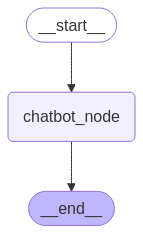

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

¡Ahora podemos probar el chatbot!

 > **Consejo**
 >
 > Puedes salir del bucle de chat en cualquier momento escribiendo `quit`, `exit` o `q`.

In [9]:
# Colors for the terminal
COLOR_GREEN = "\033[32m"
COLOR_YELLOW = "\033[33m"
COLOR_RESET = "\033[0m"


def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}{value['messages'][-1].content}")


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}Goodbye!")
            break
        
        events =stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: Hello
Assistant: Hello! It's nice to meet you. How can I assist you today? Whether you have questions, need information, or just want to chat, I'm here to help!
User: How are you doing?
Assistant: I'm just a computer program, so I don't have feelings, but I'm here and ready to help you with any questions or tasks you have! How can I assist you today?
User: Me well, I'm making a post about LangGraph, what do you think?
Assistant: LangGraph is an intriguing topic, especially if you're delving into the realm of graph-based models and their applications in natural language processing (NLP). LangGraph, as I understand, is a framework or tool that leverages graph theory to improve or provide a new perspective on NLP tasks such as text classification, information extraction, and semantic analysis. By representing textual information as graphs (nodes for entities and edges for relationships), it can offer a more nuanced understanding of the context and semantics in language data.

If you

**!Felicidades!** Has construido tu primer chatbot usando `LangGraph`. Este bot puede participar en una conversación básica tomando la entrada del usuario y generando respuestas utilizando el `LLM` que hemos definido.

Sin embargo, este bot se limita a lo que hay en sus datos de entrenamiento. Así que vamos a agregar una herramienta de búsqueda web para expandir el conocimiento del bot y hacerlo más capaz.

## Mejorar el chatbot con herramientas

Para manejar algunas consultas, nuestro chatbot no puede responder `desde su conocimiento`, así que vamos a integrar una herramienta de búsqueda web. Nuestro bot puede utilizar esta herramienta para encontrar información relevante y proporcionar mejores respuestas.

### Requisitos

Antes de comenzar, tenemos que instalar el buscador [Tavily](https://python.langchain.com/docs/integrations/tools/tavily_search/) que es un buscador web que nos permite buscar información en la web.

```bash
pip install -U tavily-python langchain_community
```

Después, tenemos que crear una [API KEY](https://app.tavily.com/home), la escribimos en nuestro archivo `.env` y la cargamos en una variable.

In [1]:
import dotenv
import os

dotenv.load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")
ANTRHOPIC_API_KEY = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

Ahora, definimos la herramienta de búsqueda web mediante [TavilySearchResults](https://python.langchain.com/api_reference/community/tools/langchain_community.tools.tavily_search.tool.TavilySearchResults.html)

In [2]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

Probamos la herramienta, vamos a hacer una búsqueda en internet

In [3]:
tool.invoke("What was the result of Real Madrid's at last match in the Champions League?")

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


[{'title': 'HIGHLIGHTS | Real Madrid 3-1 Manchester City | Champions League',
  'url': 'https://www.youtube.com/watch?v=9zW_CKWb3oM',
  'content': 'Real Madrid booked their place in the last 16 of the Champions League. The Whites followed up the impressive performance in the first leg by',
  'score': 0.63939893},
 {'title': 'Real Madrid | History | UEFA Champions League',
  'url': 'https://www.uefa.com/uefachampionsleague/history/clubs/50051--real-madrid/',
  'content': '1955/56 P W D L Final 7 5 0 2\nUEFA Champions League [...] 2010/11 P W D L Semi-finals 12 8 3 1\n2009/10 P W D L Round of 16 8 4 2 2\n2000s\n2008/09 P W D L Round of 16 8 4 0 4\n2007/08 P W D L Round of 16 8 3 2 3\n2006/07 P W D L Round of 16 8 4 2 2\n2005/06 P W D L Round of 16 8 3 2 3\n2004/05 P W D L Round of 16 10 6 2 2\n2003/04 P W D L Quarter-finals 10 6 3 1\n2002/03 P W D L Semi-finals 16 7 5 4\n2001/02 P W D L Final 17 12 3 2\n2000/01 P W D L Semi-finals 16 9 2 5\n1990s\n1999/00 P W D L Final 17 10 3 4\n1998/99

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart i

Los resultados son resúmenes de páginas que nuestro chatbot puede usar para responder preguntas.

Creamos una lista de herramientas, porque nuestro grafo necesita definir las herramientas mediante una lista.

In [3]:
tools_list = [tool]

Comenzaremos a definir nuestro gráfico. Lo siguiente es todo lo mismo que antes, excepto que hemos añadido `bind_tools` en nuestro `LLM`. Esto le permite al `LLM` saber el formato `JSON` correcto para usar si desea usar el motor de búsqueda.

Definimos el grafo

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

A continuación el `LLM` con las `bind_tools` y lo añadimos al grafo

In [5]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing
from langchain_anthropic import ChatAnthropic

# Create the LLM
# login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
# MODEL = "Qwen/Qwen2.5-72B-Instruct"
# model = HuggingFaceEndpoint(
#     repo_id=MODEL,
#     task="text-generation",
#     max_new_tokens=512,
#     do_sample=False,
#     repetition_penalty=1.03,
# )
# # Create the chat model
# llm = ChatHuggingFace(llm=model)
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTRHOPIC_API_KEY)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

Necesitamos crear una función para ejecutar las `tools_list` si se llaman. Agregamos las `tools_list` a un nuevo nodo.

Vamos a implementar la clase `BasicToolNode`, que comprueba el mensaje más reciente en el estado y llama a las `tools_list` si el mensaje contiene `tool_calls`.

Se basa en el soporte de `tool_calling` de los `LLM`s , que está disponible en `Anthropic`, `HuggingFace`, `Google Gemini` y varios otros proveedores de `LLM`.

Más tarde reemplazaremos esto con el método [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) de `LangGraph` para acelerar las cosas, pero primero lo construiremos nosotros mismos para entender cómo funciona.

Una de las cosas que usa `LangGraph` para entender 

In [6]:
import json

from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        """
        Initialize the tools

        Args:
            tools (list): The tools to use

        Returns:
            None
        """
        # Initialize the tools
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        """
        Call the node

        Args:
            inputs (dict): The inputs to the node

        Returns:
            dict: The outputs of the node
        """
        # Get the last message
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        
        # Execute the tools
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


basic_tool_node = BasicToolNode(tools=tools_list)
graph_builder.add_node("tools_node", basic_tool_node)

Hemos usado [ToolMessage](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.tool.ToolMessage.html) que pasa el resultado de ejecutar una `tool` de nuevo al `LLM`.

`ToolMessage` contiene el resultado de una invocación de una `tool`.

Es decir, en cuanto tenemos el resultado de usar una `Tool` se lo pasamos al LLM para que lo procese

Con el nodo de `basic_tool_node` (que es un objeto de la clase `BasicToolNode` que hemos creado) agregado al grafo, podemos definir los `conditional_edges`.

El `enrutador` enruta el flujo de control de un nodo al siguiente. Los `conditional_edges` por lo general, contienen declaraciones `if` para enrutar a diferentes nodos dependiendo del estado actual del grafo.

Estas funciones reciben el grafo actual `state` y devuelven una cadena o lista de cadenas que indican qué nodo o nodos llamar a continuación.

Vamos a definir una función de enrutadora llamada `route_tools_function`, que comprueba si hay `tool_calls` en la salida del chatbot.

Añadimos esta función al gráfico llamando `add_conditional_edges`, que le dice al grafo que cada vez que el nodo del `basic_tool_node` se ejecuta, se llama a la función para verificar a dónde ir a continuación.

La condición se dirigirá a `tools_node` si las llamadas de herramientas están presentes y `END` si no.

Más tarde, reemplazaremos esto con el método preconstruido `tools_condition` para ser más rápidos, pero ahora lo implementamos nosotros mismos primero ver cómo funciona.

In [7]:
def route_tools_function(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    # Get las message
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    # Router in function of last message
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools_node"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot_node",
    route_tools_function,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools_node": "tools_node", END: END},
)

Como el método de `LangGraph` ya existente `tools_condition`, nuestra función devuelve `END` si no se realizan llamadas de `tool`s. Cuando el grafo pasa a `END` éste no tiene más tareas que completar y cesa la ejecución.

Como la condición puede devolver `END`, no necesitamos establecer explícitamente un `finish_point` esta vez. Nuestro grafo ya tiene una manera de terminar

In [8]:
graph_builder.add_edge("tools_node", "chatbot_node")

Añadimos un otro nodo `edge`, pero en este caso incluye el uso de la `tool` o en final `END`

In [9]:
graph_builder.add_edge(START, "chatbot_node")

 > **Aviso** 
 >
 > Los `conditional_edge`s comienzan desde un solo nodo. Esto le dice al grafo "en cualquier momento el 'chatbot' se ejecuta el nodo, ve a las 'tools' si se llama a una herramienta o termina el bucle si responde directamente".

Compilamos el grafo

In [10]:
graph = graph_builder.compile()

Visualizamos el grafo que hemos construido.

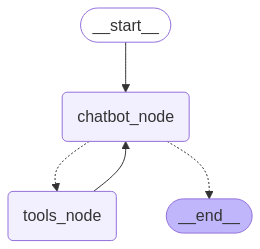

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Ahora podemos hacer preguntas al bot fuera de sus datos de entrenamiento

In [12]:
# Colors for the terminal
COLOR_GREEN = "\033[32m"
COLOR_YELLOW = "\033[33m"
COLOR_RESET = "\033[0m"


def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}{value['messages'][-1].content}")

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: How did Real Madrid fare this weekend against Leganes in La Liga?
Assistant: [{'text': "I'll help you find information about the recent match between Real Madrid and Leganes in La Liga. Let me search for the latest results.", 'type': 'text'}, {'id': 'toolu_01D1iq2Lvi3sQD8w2ZsjiraY', 'input': {'query': 'Real Madrid vs Leganes La Liga result this weekend'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
User: How did Real Madrid fare this weekend against Leganes in La Liga?
Assistant: [{"title": "Real Madrid 3-2 Leganes: Goals and highlights - LaLiga 24/25 | Marca", "url": "https://www.marca.com/en/soccer/laliga/r-madrid-leganes/2025/03/29/01_0101_20250329_186_957-live.html", "content": "The two teams have already played twice this season, with Real Madrid securing a 3-0 win in the reverse league fixture. They also met in the quarter-finals of the Copa del Rey, a game Real won 3-2.\n\nReal Madrid vs Leganes LIVE - Latest Updates\n\nMatch ends, Real Madrid 3, Leganes 2.\

Como ves, primero le he preguntado cómo quedó el Real Madrid en su último partido en la Liga contra el Villareal, como es algo de actualidad, ha decidido usar la herramienta de búsqueda, con lo que ha obtenido el resultado

Sin embargo, a continuación le he preguntado qué jugadores jugaron y no sabía de qué le hablaba, eso es porque no se mantiene el contexto de la conversación. Así que lo siguiente que vamos a hacer es agregar una memoria al agente para que pueda mantener el contexto de la conversación.

## Agregar memoria al chatbot

Nuestro chatbot ahora puede usar herramientas para responder preguntas de los usuarios, pero no recuerda el contexto de las interacciones anteriores. Esto limita su capacidad de tener conversaciones coherentes y de múltiples tandas.

`LangGraph` resuelve este problema a través de puntos de control persistentes o `checkpoints`. Si le proporcionamos un `checkpointer` al compilar el grafo y un `thread_id` al llamar al grafo, `LangGraph` guarda automáticamente el estado después de cada iteración en la conversación.

Cuando invoquemos el grafo nuevamente usando el mismo `thread_id`, el grafo cargará su estado guardado, permitiendo que el chatbot continúe donde lo dejó.

Veremos más tarde que ese `checkpointing` es mucho más potente que la simple memoria de chat: le permite guardar y reanudar estados complejos en cualquier momento para la recuperación de errores, flujos de trabajo con `human in the loop`, interacciones en el tiempo y más. Pero antes de ver todo eso, vamos a agregar puntos de control para permitir conversaciones de varias iteraciones.

In [5]:
import os
import dotenv

dotenv.load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")
ANTRHOPIC_API_KEY = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

Para empezar, creamos un `checkpointer` [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver).

In [6]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

 > **Aviso**
 >
 > Estamos usando un `checkpointer` en memoria. Esto es conveniente para nuestro caso, ya que lo guarda todo en memoria la memoria del ordenador. En una aplicación de producción, es probable que se necesite cambiar esto para usarlo con `SqliteSaver` o `PostgresSaver` y conéctarnos a nuestra propia base de datos.

A continuación, definimos el grafo.

In [7]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

Definimos la `tool`

In [8]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)
tools_list = [tool]

A continuación el `LLM` con las `bind_tools` y lo añadimos al grafo

In [9]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing
from langchain_anthropic import ChatAnthropic

# Create the LLM
# login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
# MODEL = "Qwen/Qwen2.5-72B-Instruct"
# model = HuggingFaceEndpoint(
#     repo_id=MODEL,
#     task="text-generation",
#     max_new_tokens=512,
#     do_sample=False,
#     repetition_penalty=1.03,
# )
# # Create the chat model
# llm = ChatHuggingFace(llm=model)
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTRHOPIC_API_KEY)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

Antes construimos nuestro propio `BasicToolNode` para aprender cómo funciona, ahora lo reemplazaremos con el método de LangGraph `ToolNode` y `tools_condition`, ya que estos hacen algunas cosas buenas como la ejecución paralela de API. Aparte de eso, el resto es igual que antes.

In [10]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

Añadimos el nodo de `tools_condition` al grafo

In [11]:
graph_builder.add_conditional_edges(
    "chatbot_node",
    tools_condition,
)

Añadimos el nodo de `tools` al grafo

In [12]:
graph_builder.add_edge("tools", "chatbot_node")

Añadimos el nodo de `START` al grafo

In [13]:
graph_builder.add_edge(START, "chatbot_node")

Compilamos el grafo añadiendo el `checkpointer`

In [14]:
graph = graph_builder.compile(checkpointer=memory)

Lo representamos gráficamente

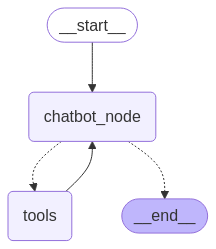

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Creamos una configuración con un `thread_id` de un usuario

In [16]:
USER1_THREAD_ID = "1"
config_USER1 = {"configurable": {"thread_id": USER1_THREAD_ID}}

In [17]:
user_input = "Hi there! My name is Maximo."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER1,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Maximo.
================================== Ai Message ==================================

Hello Maximo! It's nice to meet you. My name is Claude, and I'm an AI assistant. How can I help you today? 

Feel free to ask me any questions you might have or let me know if there's something specific you'd like assistance with.


In [18]:
user_input = "Do you remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER1,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

Yes, I remember your name! You introduced yourself as Maximo in your first message. Is there something specific I can help you with today, Maximo?


Como se puede ver, no hemos pasado una lista con los mensakes, todo está siendo gestionado por el `checkpointer`.

Si ahora probamos con otro usuario, es decir, con otro `thread_id`, veremos que el grafo no recuerda la conversación anterior.

In [20]:
USER2_THREAD_ID = "2"
config_USER2 = {"configurable": {"thread_id": USER2_THREAD_ID}}

user_input = "Do you remember my name?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER2,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

I don't have any record or memory of your name from previous conversations. As an AI assistant, I don't store personal information between sessions, so I wouldn't be able to remember your name unless you've shared it with me in this current conversation, which you haven't yet.

If you'd like, you can introduce yourself, and I'll be happy to address you by name during our current conversation.


Ahora que nuestro chatbot tiene herramientas de búsqueda y memoria, vamos a repetir el ejemplo anterior, donde le pregunto por el resultado del último partido del Real Madrid en la Liga y luego por qué jugadores jugaron.

In [21]:
USER3_THREAD_ID = "3"
config_USER3 = {"configurable": {"thread_id": USER3_THREAD_ID}}

user_input = "How did Real Madrid fare this weekend against Leganes in La Liga?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER3,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

How did Real Madrid fare this weekend against Leganes in La Liga?
================================== Ai Message ==================================

[{'text': "I'll find the latest information about Real Madrid's match against Leganes in La Liga this weekend for you. Let me search for the result.", 'type': 'text'}, {'id': 'toolu_01ELwkoSXrNXb1UHDc5Xoxuj', 'input': {'query': 'Real Madrid vs Leganes La Liga result this weekend'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01ELwkoSXrNXb1UHDc5Xoxuj)
 Call ID: toolu_01ELwkoSXrNXb1UHDc5Xoxuj
  Args:
    query: Real Madrid vs Leganes La Liga result this weekend
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Real Madrid 3-2 Leganes: Goals and highlights - LaLiga 24/25 | Marca", "url": "https://www.marca.com/en/soccer/lalig

Ahora le preguntamos por los jugadores que jugaron en el partido.

In [22]:
user_input = "Which players played against Leganes?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER3,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Which players played against Leganes?
================================== Ai Message ==================================

[{'text': "I'll search for the lineup information for the Real Madrid vs Leganes match to see which players participated.", 'type': 'text'}, {'id': 'toolu_01UbyguYBNwtcMjivg6f6mnL', 'input': {'query': 'Real Madrid vs Leganes lineup starting 11 March 29 2025'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01UbyguYBNwtcMjivg6f6mnL)
 Call ID: toolu_01UbyguYBNwtcMjivg6f6mnL
  Args:
    query: Real Madrid vs Leganes lineup starting 11 March 29 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "CONFIRMED lineups: Real Madrid vs Leganés, 2025 La Liga", "url": "https://www.managingmadrid.com/2025/3/29/24396638/real-madrid-vs-leganes-2025-la-liga-live-onli

Tras mucho buscar, al final lo encuentra. Por lo que ya tenemos un chatbot con `tools` y memoria.

Por ahora, hemos creado unos `checkpoints` en tres hilos diferentes. Pero, ¿qué entra en cada `checkpoint`? Para inspeccionar el estado de un grafo para una configuración dada podemos usar el método `get_state(config)`.

In [23]:
snapshot = graph.get_state(config_USER3)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='How did Real Madrid fare this weekend against Leganes in La Liga?', additional_kwargs={}, response_metadata={}, id='533ee07d-517a-4286-98f6-13a7f3f61228'), AIMessage(content=[{'text': "I'll find the latest information about Real Madrid's match against Leganes in La Liga this weekend for you. Let me search for the result.", 'type': 'text'}, {'id': 'toolu_01ELwkoSXrNXb1UHDc5Xoxuj', 'input': {'query': 'Real Madrid vs Leganes La Liga result this weekend'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01Ya8M5awAkPmsz1vmKj95A1', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 431, 'output_tokens': 99}, 'model_name': 'claude-3-7-sonnet-20250219'}, id='run-bb25993a-b3a5-45d9-b1fd-61166e24f1d3-0', tool_calls=[{'name': 'tavily_search_results_jso

Si queremos ver el siguiente nodo a procesar, podemos usar el atributo `next`

In [24]:
snapshot.next

()

dado que el grafo ha finalizado, `next` está vacío. Si obtienes un estado desde dentro de una invocación del grafo, next indica qué nodo se ejecutará a continuación.

La instantánea anterior (`snapshot`) contiene los valores de estado actuales, la configuración correspondiente y el siguiente nodo (`next`) a procesar. En nuestro caso, el gráfico ha alcanzado el estado `END`, por eso `next` está vacío.

**¡Felicidades!** Nuestro chatbot ahora puede mantener el estado de conversación en todas las sesiones gracias al sistema de puntos de control (`checkpoints`) de `LangGraph`. Esto abre posibilidades para interacciones más naturales y contextuales. El control de `LangGraph` incluso maneja estados de grafos complejos.

## Human in the loop

Aunque un agente puede realizar tareas, para según que tareas, es necesario que haya una supervisión humana. A esto se le llama `human in the loop`. Así que vamos a ver cómo se puede hacer esto con `LangGraph`.

La capa de [persistencia](https://langchain-ai.github.io/langgraph/concepts/persistence/) de `LangGraph` admite flujos de trabajo con humanos en el bucle, lo que permite que la ejecución se detenga y reanude en función de los comentarios de los usuarios. La interfaz principal de esta funcionalidad es la función [interrupt](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#interrupt). Llamando a `interrupt` dentro de un nodo se detendrá la ejecución. La ejecución se puede reanudar, junto con la nueva aportación del humano, pasada en una primitiva [Command](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#the-command-primitive). `interrupt` es similar al comando de Python `input()`, pero con algunas consideraciones extra.

Vamos a repetir el código anterior, pero haremos un cambio, que es agregar una simple herramienta `human_assistance`. Esta herramienta utiliza `interrupt` para recibir información de un humano.

Primero cargamos los valores de las API KEYs

In [1]:
import os
import dotenv

dotenv.load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")
ANTRHOPIC_API_KEY = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

Creamos el grafo

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

Definimos la `tool` de búsqueda

In [3]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

Ahora creamos la `tool` de ayuda humana

In [4]:
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

@tool
def human_assistance(query: str) -> str:
    """
    Request assistance from a human expert. Use this tool ONLY ONCE per conversation.
    After receiving the expert's response, you should provide an elaborated response to the user based on the information received
    based on the information received, without calling this tool again.

    Args:
        query: The query to ask the human expert.

    Returns:
        The response from the human expert.
    """
    human_response = interrupt({"query": query})
    return human_response["data"]

`LangGraph` obtiene información de las herramientas mediante la documentación de la herramienta, es decir, el docstring de la función. Por lo que es muy importante generar un buen docstring para la herramienta.

Creamos una lista de `tools`

In [5]:
tools_list = [search_tool, human_assistance]

A continuación el `LLM` con las `bind_tools` y lo añadimos al grafo

In [6]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing
from langchain_anthropic import ChatAnthropic

# Create the LLM
# login(token=HUGGINGFACE_TOKEN)
# MODEL = "Qwen/Qwen2.5-72B-Instruct"
# model = HuggingFaceEndpoint(
#     repo_id=MODEL,
#     task="text-generation",
#     max_new_tokens=512,
#     do_sample=False,
#     repetition_penalty=1.03,
# )
# # Create the chat model
# llm = ChatHuggingFace(llm=model)
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTRHOPIC_API_KEY)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

Si te fijas, hemos cambiado la forma de definir la función `chatbot_function`, ya que ahora tiene que manejar la interrupción.

Añadimos la `tool_node` al grafo

In [7]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

Añadimos el nodo de `START` al grafo

In [8]:
graph_builder.add_edge(START, "chatbot_node")

Creamos un `checkpointer` [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver).

In [9]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Compilamos el grafo con el `checkpointer`

In [10]:
graph = graph_builder.compile(checkpointer=memory)

Lo representamos gráficamente

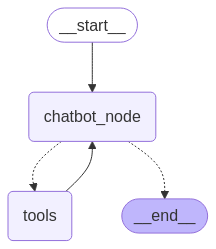

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Ahora solicitemos el chatbot con una pregunta que involucrará a la nueva herramienta `human_assistance`:

In [12]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================

[{'text': "I'd be happy to help you request expert assistance for building an AI agent. To make the request most useful, it would help to know more about your specific needs or challenges with AI agent development.\n\nLet me request assistance from a human expert on your behalf:", 'type': 'text'}, {'id': 'toolu_01PnuA9NDYpqbUgJjWMnhCNu', 'input': {'query': 'The user is looking for guidance on building an AI agent. Could you provide expert advice on best practices, frameworks, or approaches for AI agent development? Any insights on architecture, tools, or common pitfalls would be helpful.'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01PnuA9NDYpqbUgJjWMnhCNu)
 Call ID: toolu_01PnuA9NDYpqbUgJjW

Como se puede ver, el chatbot generó una llamada de herramienta de asistencia humana.

``` markdown
Tool Calls:
  human_assistance (0)
 Call ID: 0
  Args:
    query: I need some expert guidance for building an AI agent. Could you provide advice on key considerations, best practices, and potential pitfalls to avoid?
```

pero luego la ejecución se ha interrumpido. Vamos a ver el estado del grafo

In [13]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

Vemos que se detuvo en el nodo de `tools`. Analizamos cómo se ha definido la herramienta `human_assistance`.

``` python
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

@tool
def human_assistance(query: str) -> str:
    """
    Request assistance from a human expert. Use this tool ONLY ONCE per conversation.
    After receiving the expert's response, you should provide an elaborated response to the user based on the information received
    based on the information received, without calling this tool again.

    Args:
        query: The query to ask the human expert.

    Returns:
        The response from the human expert.
    """
    human_response = interrupt({"query": query})
    return human_response["data"]
```

Llamando a la herramienta `interrupt` se detendrá la ejecución, similar al la función de Python `input()`.

El progreso se mantiene en función de nuestra elección de [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries). Es decir, la elección de dónde se guarda el estado del grafo. Así que si estamos persistiendo (guardando el estado del grafo) con una base de datos como `Postgres`, podemos reanudar la ejecución en cualquier momento siempre y cuando la base de datos esté viva.

Aquí estamos persistiendo (guardando el estado del grafo) con el puntero de verificación en memoria, por lo que podemos reanudar en cualquier momento mientras nuestro kernel de Python se esté ejecutando. En mi caso, mientras no resetee el kernel de mi Jupyter Notebook.

Para reanudar la ejecución, pasamos un objeto [Command](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#the-command-primitive) que contiene los datos esperados por la herramienta. El formato de estos datos se puede personalizar en función de nuestras necesidades. Aquí, solo necesitamos un diccionario con una key `data`

In [14]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    "It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "I'd be happy to help you request expert assistance for building an AI agent. To make the request most useful, it would help to know more about your specific needs or challenges with AI agent development.\n\nLet me request assistance from a human expert on your behalf:", 'type': 'text'}, {'id': 'toolu_01PnuA9NDYpqbUgJjWMnhCNu', 'input': {'query': 'The user is looking for guidance on building an AI agent. Could you provide expert advice on best practices, frameworks, or approaches for AI agent development? Any insights on architecture, tools, or common pitfalls would be helpful.'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01PnuA9NDYpqbUgJjWMnhCNu)
 Call ID: toolu_01PnuA9NDYpqbUgJjWMnhCNu
  Args:
    query: The user is looking for guidance on building an AI agent. Could you provide expert advice on best practices, frameworks, or approaches for AI agent

Como vemos, el chatbot ha esperado a que un humano le proporcione la respuesta y luego ha generado una respuesta basada en la información recibida. Le hemos pedido por la ayuda sobre un experto sobre cómo crear agentes, el humano le ha dicho que lo mejor es usar LangGraph, y el chatbot ha generado una respuesta basada en esa información.

Pero sigue teniendo la posibilidad de realizar búsquedas en la web. Así que ahora le vamos a pedir las últimas noticias sobre LangGraph.

In [15]:
user_input = "What's the latest news about LangGraph?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What's the latest news about LangGraph?
================================== Ai Message ==================================

[{'text': "I'll search for the latest news about LangGraph for you:", 'type': 'text'}, {'id': 'toolu_019tvCikWprw4kWhUNtoawAY', 'input': {'query': 'latest news about LangGraph AI framework updates 2023 2024'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_019tvCikWprw4kWhUNtoawAY)
 Call ID: toolu_019tvCikWprw4kWhUNtoawAY
  Args:
    query: latest news about LangGraph AI framework updates 2023 2024
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangChain State of AI 2024 Report", "url": "https://blog.langchain.dev/langchain-state-of-ai-2024/", "content": "As companies are getting more serious about incorporating AI agents across various industries,

Ha buscado las últimas noticias sobre LangGraph y ha generado una respuesta basada en la información recibida.

## Personalización del estado

 > Nota: Este apartado lo vamos a hacer usando Sonnet 3.7, ya que a día de la escritura del post, es el mejor modelo para uso con agentes, y es el único que entiende cuando tiene que llamar a las tools y cuando no

Hasta ahora, hemos confiado en un estado simple con una entrada, una lista de mensajes. Se puede llegar lejos con este estado simple, pero si se desea definir un comportamiento complejo sin depender de la lista de mensajes, se pueden agregar campos adicionales al estado.

Aquí vamos a ver un nuevo escenario, en el que el chatbot está utilizando la herramienta de búsqueda para encontrar información específica, y reenviándola a un ser humano para su revisión. Vamos a hacer que el chatbot investigue el cumpleaños de una entidad. Agregaremos `name` y `birthday` claves del estado.

Primero cargamos los valores de las API KEYs

In [16]:
import os
import dotenv

dotenv.load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

Creamos el nuevo estado

In [17]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

Agregar esta información al estado hace que sea fácilmente accesible por otros nodos del grafo (por ejemplo, un nodo downstram que almacena o procesa la información), así como la capa de persistencia del grafo.

Ahora creamos el grafo

In [18]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

Definimos la `tool` de búsqueda

In [19]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

Ahora creamos la tool de asistencia humana. En esta tool rellenaremos las claves de estado dentro de nuestra herramienta `human_assistance`. Esto permite a un ser humano revisar la información antes de que se almacene en el estado. Volveremos a usar `Command`, esta vez para emitir una actualización de estado desde el interior de nuestra herramienta.

In [21]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """
    Request assistance from a human expert. Use this tool ONLY ONCE per conversation.
    After receiving the expert's response, you should provide an elaborated response to the user based on the information received
    based on the information received, without calling this tool again.

    Args:
        query: The query to ask the human expert.

    Returns:
        The response from the human expert.
    """
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )

    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"

    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

Hemos usado [ToolMessage](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.tool.ToolMessage.html) que se usa para pasar el resultado de ejecutar una `tool` de nuevo a un modelo y [InjectedToolCallId](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.base.InjectedToolCallId.html)

Creamos una lista de `tools`

In [22]:
tools_list = [search_tool, human_assistance]

A continuación el `LLM` con las `bind_tools` y lo añadimos al grafo

In [ ]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing
from langchain_anthropic import ChatAnthropic


# Create the LLM
# login(token=HUGGINGFACE_TOKEN)
# MODEL = "mistralai/Mistral-Small-3.1-24B-Instruct-2503"
# model = HuggingFaceEndpoint(
#     repo_id=MODEL,
#     task="text-generation",
#     max_new_tokens=512,
#     do_sample=False,
#     repetition_penalty=1.03,
# )
# Create the chat model
# llm = ChatHuggingFace(llm=model)
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

Añadimos la `tool` al grafo

In [24]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

Añadimos el nodo de `START` al grafo

In [25]:
graph_builder.add_edge(START, "chatbot_node")

Creamos un `checkpointer` [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver).

In [26]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Compilamos el grafo con el `checkpointer`

In [27]:
graph = graph_builder.compile(checkpointer=memory)

Lo representamos gráficamente

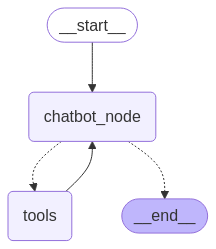

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Vamos a pedir a nuestro chatbot que busque el "cumpleaños" de la biblioteca de `LangGraph`.

Dirigiremos al chatbot hata la herramienta `human_assistance` una vez que tenga la información requerida. Los argumentos `name` y `birthday` son obligatorios para la herramienta `human_assistance`, así que obligan al chatbot a generar propuestas para estos campos.

In [29]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================

[{'text': "I'll help you find out when LangGraph was released. Let me search for that information first.", 'type': 'text'}, {'id': 'toolu_01WdjhcH39pTnMbU5xP1Tzs3', 'input': {'query': 'when was LangGraph released date of launch'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01WdjhcH39pTnMbU5xP1Tzs3)
 Call ID: toolu_01WdjhcH39pTnMbU5xP1Tzs3
  Args:
    query: when was LangGraph released date of launch
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Introducing LangGraph - LangChain - Changelog", "url": "https://changelog.langchain.com/announcements/week-of-1-22-24-langchain-r

Se ha parado por el `interrupt` en la herramienta `human_assistance`. En este caso, el chatbot no identificó la fecha correcta, por lo que podemos introducirla nosotros mismos.

In [30]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Based on my search, I've found conflicting information about when LangGraph was released. One source indicates that LangGraph was launched on January 22, 2024, while another mentions January 2023. Let me submit this to a human expert for verification.", 'type': 'text'}, {'id': 'toolu_018ue7nu8oBgN4XUbUWGrX9a', 'input': {'name': 'LangGraph release date verification', 'birthday': 'January 22, 2024'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_018ue7nu8oBgN4XUbUWGrX9a)
 Call ID: toolu_018ue7nu8oBgN4XUbUWGrX9a
  Args:
    name: LangGraph release date verification
    birthday: January 22, 2024
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

Thank you 

In [31]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

### Actualización manual del estado

LangGraph proporciona un alto grado de control sobre el estado de aplicación. Por ejemplo, en cualquier punto (incluso cuando se interrumpe), podemos soreescribir manualmente una key del estado usando `graph.update_state`:

Vamos a actualizar el `name` del estado a `LangGraph (library)`.

In [16]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0067be-cd1d-6fd4-8006-fa5a987d1d2c'}}

Si ahora vemos el estado con `graph.get_state(config)` veremos que el `name` se ha actualizado.

In [17]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

Las actualizaciones de estado manuales generarán una traza en `LangSmith`. Se pueden usar para controlar flujos de trabajo de `human in the loop`, como se puede ver en esta [guía](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/edit-graph-state/).

## Checkpoints

En un flujo de trabajo típico de un chatbot, el usuario interactúa con el chatbot una o más veces para realizar una tarea. En las secciones anteriores, vimos cómo agregar memoria y un `human in the loop` para poder verificar nuestro estado de gráfico y controlar las respuestas futuras.

Pero, a lo mejor un usuario quiere comenzar desde una respuesta anterior y o quiere `ramificar` para explorar un resultado separado. Esto es útil para aplicaciones de agentes, cuando un flujo falla pueden volver a un checkpoint anterior y probar otra estrategia.

`LangGraph` da esta posibilidad mediante los `checkpoints`

Primero cargamos los valores de las API KEYs

In [1]:
import os
import dotenv

dotenv.load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

Creamos el nuevo estado

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

Ahora creamos el grafo

In [3]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

Definimos la `tool` de búsqueda

In [4]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

Creamos una lista de `tools`

In [5]:
tools_list = [search_tool]

A continuación el `LLM` con las `bind_tools` y lo añadimos al grafo

In [6]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing
from langchain_anthropic import ChatAnthropic


# Create the LLM
# login(token=HUGGINGFACE_TOKEN)
# MODEL = "Qwen/Qwen2.5-72B-Instruct"
# model = HuggingFaceEndpoint(
#     repo_id=MODEL,
#     task="text-generation",
#     max_new_tokens=512,
#     do_sample=False,
#     repetition_penalty=1.03,
# )
# # Create the chat model
# llm = ChatHuggingFace(llm=model)
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    return {"messages": [message]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

Añadimos la `tool` al grafo

In [7]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

Añadimos el nodo de `START` al grafo

In [8]:
graph_builder.add_edge(START, "chatbot_node")

Creamos un `checkpointer` [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver).

In [9]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Compilamos el grafo con el `checkpointer`

In [10]:
graph = graph_builder.compile(checkpointer=memory)

Lo representamos gráficamente

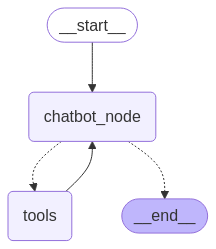

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Hagamos que nuestro gráfico dé un par de pasos. Cada paso será guardado en el historial del estado.

Hacemos la primera llamada al modelo

In [12]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "I'd be happy to research LangGraph for you. Let me search for some up-to-date information about it.", 'type': 'text'}, {'id': 'toolu_011EHHsHURw6YLkeLmGv34Li', 'input': {'query': 'LangGraph framework AI programming language models'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_011EHHsHURw6YLkeLmGv34Li)
 Call ID: toolu_011EHHsHURw6YLkeLmGv34Li
  Args:
    query: LangGraph framework AI programming language models
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Which AI Agent framework should i use? (CrewAI, Langgraph ...", "url": "https://medium.com/@aydinKerem/which-ai-agent-framework-i-should-use-crewai-langgra

Y ahora la segunda llamada

In [13]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

Building an autonomous agent with LangGraph sounds like a great idea! It's definitely one of the framework's strengths.

Here's what you should know about building autonomous agents with LangGraph:

## Getting Started with Autonomous Agents in LangGraph

### Key Components for Your Agent

1. **Agent State Management**
   - Define a state class to track your agent's knowledge, progress, and goals
   - LangGraph's explicit state management is perfect for this, as it helps you track context across multiple steps

2. **Agent Decision-Making Flow**
   - Design your agent's thinking process as a graph
   - Include nodes for reasoning, planning, tool-calling, and action execution
   - Use conditional edges to create dynamic workflows (e.g., "if task complete, move to 

Ahora que hemos hecho dos llamadas al modelo, vamos a ver el historial del estado.

In [14]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 2:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  10 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  9 Next:  ('chatbot_node',)
--------------------------------------------------------------------------------
Num Messages:  8 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot_node',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot_node',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot_node',)
--------------------

Hemos guardado en `to_replay` el estado del grafo en cada iteración. Podemos volver a un estado pasado y continuar el flujo desde allí.

Para reanudar el flujo en ese estado hay que usar el método `next`

In [15]:
print(to_replay.next)

('tools',)


La configuración del checkpoint contiene el `checkpoint_id`, que es un timestamp del flujo

In [16]:
print(to_replay.config)

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f00e610-5567-6dfc-8001-aa1ef75568f5'}}


Dando este `checkpoint_id` a `LangGrah` carga el estado en ese momento del flujo

In [17]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "I'd be happy to research LangGraph for you. Let me search for some up-to-date information about it.", 'type': 'text'}, {'id': 'toolu_011EHHsHURw6YLkeLmGv34Li', 'input': {'query': 'LangGraph framework AI programming language models'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_011EHHsHURw6YLkeLmGv34Li)
 Call ID: toolu_011EHHsHURw6YLkeLmGv34Li
  Args:
    query: LangGraph framework AI programming language models
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Which AI Agent framework should i use? (CrewAI, Langgraph ...", "url": "https://medium.com/@aydinKerem/which-ai-agent-framework-i-should-use-crewai-langgraph-majestic-one-and-pure-code-e16a6e4d9252", "content": "2. LangGraph\nLangGraph is a framework built upon the Langchain library and uses its many 

El grafo reanudó la ejecución desde el nodo `tool calls`.